In [1]:
from baseline_cnn import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [3]:
# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

CUDA is supported


In [4]:
net = models.resnet18(pretrained=True)
num_ftrs = net.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
net.fc = nn.Linear(num_ftrs, 43)


# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     net = nn.DataParallel(net)


net = net.to(computing_device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.001)

# Observe that all parameters are being optimized
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# # Decay LR by a factor of 0.1 every 7 epochs
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [5]:
transform = transforms.Compose([transforms.Resize(32), transforms.CenterCrop(32), transforms.ToTensor()])
trainset = loader('train.pickle', transform=transform)
validset = loader('valid.pickle', transform=transform)

batch_size = 100
random_seed= 196801 #should be torch.manuel_seed(42) ?

shuffle_dataset = True

tsize = len(trainset)
vsize = len(validset)
tidxs = list(range(tsize))
vidxs = list(range(vsize))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(tidxs)
    
    np.random.seed(random_seed)
    np.random.shuffle(vidxs)

tsampler = SubsetRandomSampler(tidxs)
vsampler = SubsetRandomSampler(vidxs)


#make shuffle true for real training
train = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                    sampler=tsampler)

valid = torch.utils.data.DataLoader(validset, batch_size=batch_size,
                                    sampler=vsampler)

In [6]:
root_dir = ''
label_names = pickle.load(open(root_dir + 'labels.pickle', 'rb'))

In [7]:
len(label_names)

43

In [8]:
label_names[17]

'No entry'

torch.Size([3, 32, 32]) tensor(17, dtype=torch.uint8)
17 No entry


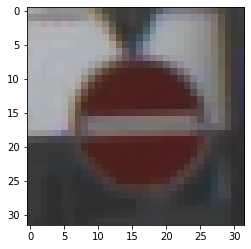

In [9]:
j = 1
torch.manual_seed(random_seed)
for i, (images, labels) in enumerate(train, 0):
    print(images[j].shape, labels[j])
    img = transforms.ToPILImage()(images[j]).convert("RGB")
    
    cls = labels[j].item()
    print(cls, label_names[cls])
    imshow(img)
    break

In [10]:
pathdir = 'models/resnetAdam_best'

In [11]:
total_loss = []
total_accu = []

train_losses = []
train_accuracies = []

avg_minibatch_loss = []
avg_minibatch_accu = []
N = 50

all_models = []

valid_losses = []
valid_accuracies = []

xnloss = []
best_loss = float('inf')
start = time.monotonic()

torch.manual_seed(random_seed)

#num of epochs
n_epochs = 25
stop = True



#Helper function for calculating accuracy
def calculate_accu(outputs, labels, batch_size):
    num_correct = torch.sum(torch.max(outputs, dim = 1)[1] == labels).item()
    return num_correct / batch_size

for epoch in range(n_epochs):
    
    epoch_start = time.monotonic()
    N_minibatch_loss = 0.0
    net.train()
    
    N_minibatch_accu = 0.0

    # Get the next minibatch of images, labels for training
    for minibatch_count, (images, labels) in enumerate(train, 0):
        print('mini_batch %d\r' % minibatch_count, end="")
        # Zero out the stored gradient (buffer) from the previous iteration
        optimizer.zero_grad()
        
        labels = labels.type(torch.LongTensor)
        # Put the minibatch data in CUDA Tensors and run on the GPU if supported
        images, labels = images.to(computing_device), labels.to(computing_device)
        # Perform the forward pass through the network and compute the loss
        outputs = net(images)
        
        
        
        loss = criterion(outputs, labels)
        accu = calculate_accu(outputs, labels, batch_size)
        # Automagically compute the gradients and backpropagate the loss through the network
        loss.backward()

        # Update the weights
        optimizer.step()    
        # Add this iteration's loss to the total_loss
        total_loss.append(loss.item())
        total_accu.append(accu)
        
        N_minibatch_loss += loss #N_minibatch_loss += loss.item()
        N_minibatch_accu += accu
        
        if minibatch_count % N == 49:
            #Print the loss averaged over the last N mini-batches
            N_minibatch_loss /= N
            N_minibatch_accu /= N
            
            print('Epoch %d, avg miba %d loss: %.3f\r' % (epoch + 1, minibatch_count+1, N_minibatch_loss), end="")
            # Add the averaged loss over N minibatches and reset the counter
            avg_minibatch_loss.append(N_minibatch_loss)
            avg_minibatch_accu.append(N_minibatch_accu)
            
            N_minibatch_loss = 0.0
            N_minibatch_accu = 0.0
    
#     scheduler.step()
    train_losses.append(np.average(total_loss))
    train_accuracies.append(np.average(total_accu))
    
    print("Finished", epoch + 1, "epochs of training")
    # TODO: Implement validation #with torch.no_grad():
    
    epoch_RT = time.monotonic() - epoch_start
    formattedTime = time.strftime("%H:%M:%S", time.gmtime(epoch_RT))
    print('RUNTIME FOR EPOCH: ', epoch + 1, formattedTime)
    
   
    print("now doing validation performance")
    
    val_start = time.monotonic()
    net.eval()
    
    with torch.no_grad():
        
        valid_loss = 0
        valid_accu = 0
        
        for minibatch_count, (images, labels) in enumerate(valid, 0):
            
            #Apply current model to the data
            labels = labels.type(torch.LongTensor)
            images, labels = images.to(computing_device), labels.to(computing_device)
            outputs = net(images)
            
            valid_accu += calculate_accu(outputs, labels, batch_size)
            valid_loss += criterion(outputs, labels).item()
        
        avg_valid_accu = valid_accu/minibatch_count
        avg_valid_loss = valid_loss/minibatch_count
        
        val_RT = time.monotonic() - val_start
        formattedTime = time.strftime("%H:%M:%S", time.gmtime(val_RT))
        print('RUNTIME OF VAL PERFORMANCE: ', formattedTime)   
        
        print("Loss for validation set is %.3f" % avg_valid_loss)
        print("Accuracy for validation set is %.2f" % (avg_valid_accu * 100), "%")
            
        if len(xnloss) < 2:
            xnloss.append(avg_valid_loss)
        elif xnloss[-2] < xnloss[-1] < avg_valid_loss:
            xnloss.append(avg_valid_loss)
            if stop:
                print("EARLY STOPPED AT EPOCH: ", epoch + 1)
                break
        else:
            xnloss.append(avg_valid_loss)
            
        valid_accuracies.append(avg_valid_accu)
    
    duration = time.monotonic() - start
    formattedTime = time.strftime("%H:%M:%S", time.gmtime(duration))
    print('TOTAL RUNTIME SO FAR :) ', formattedTime)
    
    
    #     path = 'model_states/states_' + 'ep' + str(itrs+1) + '.pt'
    #if we got a better loss, save the model_state_dict()
    if xnloss[-1] < best_loss:
        path = pathdir +  '.pt'
        torch.save(net.state_dict(), path)
        print('new best loss')
        best_loss = xnloss[-1]
        
    print()
    
finalTime = time.monotonic() - start
formattedTime = time.strftime("%H:%M:%S", time.gmtime(finalTime))
print('Total time with ESing: ', formattedTime)

Finished 1 epochs of training.195
RUNTIME FOR EPOCH:  1 00:00:12
now doing validation performance
RUNTIME OF VAL PERFORMANCE:  00:00:00
Loss for validation set is 0.398
Accuracy for validation set is 90.20 %
TOTAL RUNTIME SO FAR :)  00:00:12
new best loss

Finished 2 epochs of training.104
RUNTIME FOR EPOCH:  2 00:00:11
now doing validation performance
RUNTIME OF VAL PERFORMANCE:  00:00:00
Loss for validation set is 0.365
Accuracy for validation set is 91.07 %
TOTAL RUNTIME SO FAR :)  00:00:25
new best loss

Finished 3 epochs of training.065
RUNTIME FOR EPOCH:  3 00:00:11
now doing validation performance
RUNTIME OF VAL PERFORMANCE:  00:00:00
Loss for validation set is 0.369
Accuracy for validation set is 91.75 %
TOTAL RUNTIME SO FAR :)  00:00:37

Finished 4 epochs of training.051
RUNTIME FOR EPOCH:  4 00:00:11
now doing validation performance
RUNTIME OF VAL PERFORMANCE:  00:00:00
Loss for validation set is 0.348
Accuracy for validation set is 91.55 %
TOTAL RUNTIME SO FAR :)  00:00:49
n

In [12]:
outputs.shape

torch.Size([10, 43])

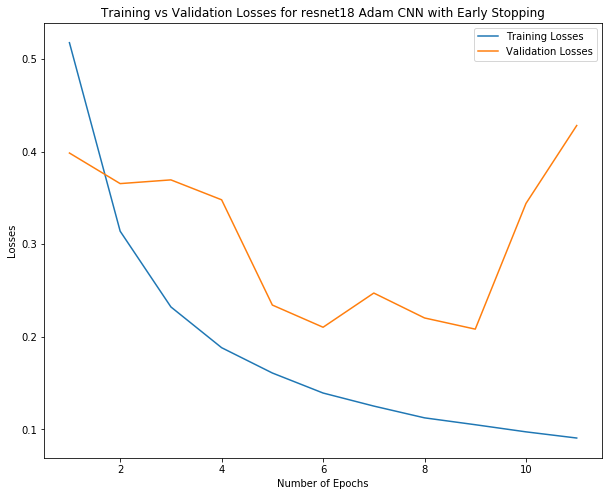

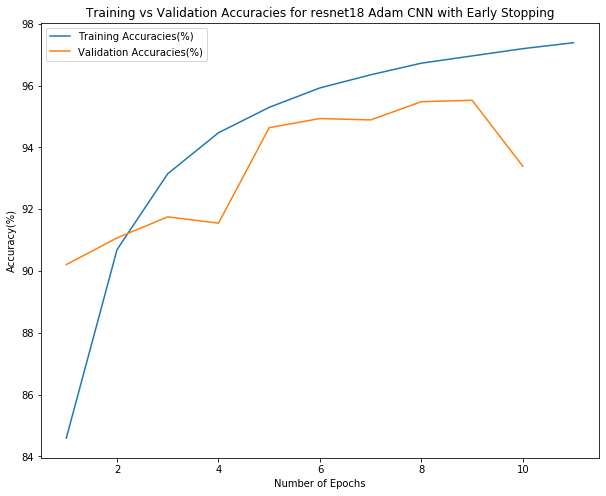

In [13]:
# path = 'saved_models/' + time.strftime("%b%d/", time.localtime())
# os.makedirs(path, 0o777, exist_ok=True)
# lastmodel = path  + 'lastModel.pt'
# torch.save(net, 'baseline_fold2.pt')

graph_path = 'graphs/resnetAdam' + time.strftime("%I_%M%p", time.localtime())  + '_losses.png'
# os.makedirs(path, 0o777, exist_ok=True)
# graph_savpth = graph_path  + time.strftime("%I_%M%p", time.localtime()) + '.png'


graph_title = 'Training vs Validation Losses for resnet18 Adam CNN with Early Stopping'

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot()
ax.plot(np.arange(1, len(train_losses) + 1), train_losses, label='Training Losses')
ax.plot(np.arange(1, len(xnloss) + 1), xnloss, label='Validation Losses')
ax.set(xlabel='Number of Epochs', ylabel='Losses',
           title=graph_title)
leg = ax.legend() #loc=4)
fig.savefig(graph_path)

graph_title = 'Training vs Validation Accuracies for resnet18 Adam CNN with Early Stopping'

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot()
ax.plot(np.arange(1, len(train_accuracies) + 1), np.array(train_accuracies) * 100, label='Training Accuracies(%)')
ax.plot(np.arange(1, len(valid_accuracies) + 1), np.array(valid_accuracies) * 100, label='Validation Accuracies(%)')
ax.set(xlabel='Number of Epochs', ylabel='Accuracy(%)',
           title=graph_title)
leg = ax.legend() #loc=4)

accupath = 'graphs/resnetAdam' + time.strftime("%I_%M%p", time.localtime()) + '_accus.png'
fig.savefig(accupath)
plt.show()

In [14]:
test_set = loader('test.pickle', transform=transform)

tstsize = len(test_set)
tstidxs = list(range(tstsize))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(tstidxs)
    
tstsampler = SubsetRandomSampler(tstidxs)
test = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                    sampler=tstsampler)

In [15]:
tstsize

12630

In [16]:
path

'models/resnetAdam_best.pt'

In [17]:
# model=Nnet()
net.load_state_dict(torch.load(path))

# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     model = nn.DataParallel(model)

net = net.to(computing_device)
# model=Nmodel().to(computing_device)
# model.apply(weights_init)

# Print the model
net.eval()
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
def per_class_model_performance(performances):
    
    perf_df = []
    
    #for each class, calculate accuracy, recall, precision and bcr
    for i in range(len(performances)):
        
        cur_perf = performances[i]
        accu, recall, precision, bcr = get_per_class_values(cur_perf)
        
        perf_df.append([accu, precision, recall, bcr])
        
    #make it to a dataframe
    perf_df = pd.DataFrame(perf_df)
    perf_df.columns = ['Accuracy', 'Precision', 'Recall', 'BCR']
    
    return perf_df
 

#get measurement recall, accuracy, precision and bcr value for the current class
def get_per_class_values(cur_perf):    
    
    tp = cur_perf['TP']
    fp = cur_perf['FP']
    tn = cur_perf['TN']
    fn = cur_perf['FN']
    
    #accuracy
    accu = (tp + tn)/(tp + tn + fp + fn)
    
    #recall
    if tp + fn == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)
    
    #precision
    if fp + tp == 0:
        precision = 0
    else:
        precision = tp / (fp + tp)
        
    #bcr
    bcr = (precision + recall) / 2
    
    return accu, recall, precision, bcr


# In[ ]:


#Apply to test set and test Performances
all_class_performance = []
test_accuracies = []

#turn list into a sparse matrix
def make_matrix(lst):
    mat = []
    for i in lst:
        cur = [0] * 201
        cur[i] = 1
        mat.append(cur)
    return np.array(mat)


for i in range(44):
    all_class_performance.append({'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0})

    
torch.manual_seed(random_seed)

with torch.no_grad(): 
    
    test_accu = 0
    
    for minibatch_count, (images, labels) in enumerate(test, 0):
        
#         print("current minibatch: ", minibatch_count)
        
        labels = labels.type(torch.LongTensor)
        # Put the minibatch data in CUDA Tensors and run on the GPU if supported
        images, labels = images.to(computing_device), labels.to(computing_device) 
        outputs = net(images)
        
        test_accu += calculate_accu(outputs, labels, batch_size)
        
        predictions = torch.max(outputs, dim = 1)[1]

        pred = make_matrix(predictions.tolist())
        lab = make_matrix(labels.tolist())

        for i in range(pred.shape[0]):
            for j in range(44):
                if (pred[i][j] == 1) and (lab[i][j] == 1):
                    all_class_performance[j]['TP'] += 1
                elif (pred[i][j] == 1) and (lab[i][j] == 0):
                    all_class_performance[j]['FP'] += 1
                elif (pred[i][j] == 0) and (lab[i][j] == 0):
                    all_class_performance[j]['TN'] += 1
                else:
                    all_class_performance[j]['FN'] += 1
                    
    test_accuracies = (test_accu/minibatch_count)

print('The test accuracy is ' + "{0:.2f}".format(100 * test_accu/minibatch_count) + '%')

The test accuracy is 94.38%


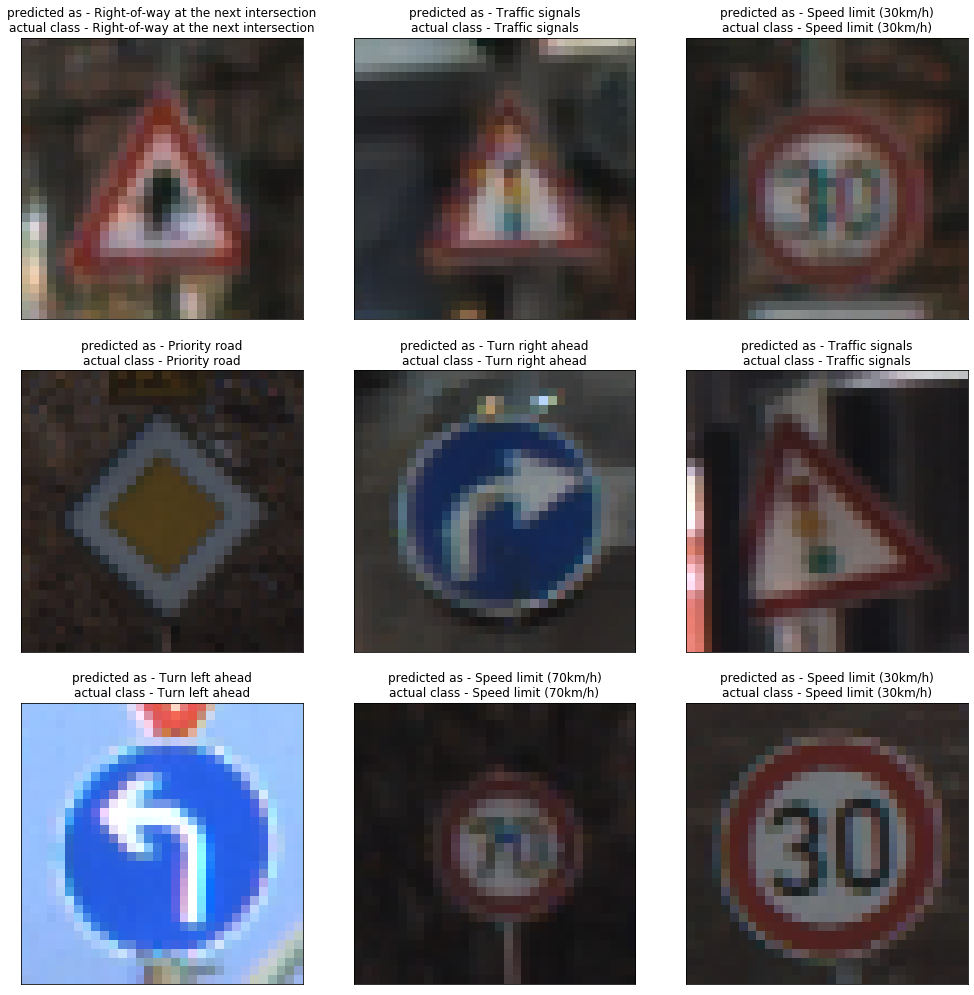

In [19]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(14, 14),
                            subplot_kw={'xticks': [], 'yticks': []})

samples = [i for i in range(9)]

for ax, n in zip(axs.flat, samples):
    img = transforms.ToPILImage()(images[n].cpu()).convert("RGB")
    pred = torch.argmax(outputs[n]).item()
    cls = labels[n].item()
    preded = label_names[pred]

    title = 'predicted as - ' + str(preded) + '\nactual class - ' + str(label_names[cls])
    ax.imshow(img)
    ax.set_title(title)

plt.tight_layout()
fig.savefig('resnetAdam_samples.png')
plt.show()

1 Speed limit (30km/h)


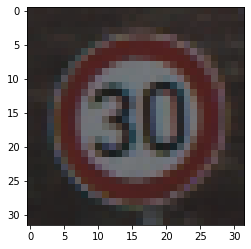

In [20]:
img = transforms.ToPILImage()(images[n].cpu()).convert("RGB")

cls = labels[n].item()
print(cls, label_names[pred])
imshow(img)

In [21]:
rem = int((10000 * test_accu / minibatch_count) % 100)
accuFormat = "{}_{}".format(int(100 * test_accu/minibatch_count), rem)
print(accuFormat)

94_38


In [22]:
testAccu = accuFormat + 'accu'

config_path = 'configs/resnetAdam' + testAccu + '.txt'
f = open(config_path, "w")
f.write(str(net))
f.close()

model_path = 'models/resnetAdam' + testAccu + '.pt'
torch.save(net.state_dict(), model_path)

In [23]:
for idx, m in enumerate(net.modules()):
    if idx == 1:
        print(idx, m)
        
#         inputs = utils.make_grid(m.weight.cpu().data, normalize=True)
        
        filters = m.weight.cpu().data.numpy()
#         print(filters, filters.shape)
#         print(filters[1])
        mins = np.min(filters, axis=0)
        maxs = np.max(filters, axis=0)
        kernels = (filters - mins) / (maxs - mins)
#         print(kernels)
        
        break

1 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [24]:
kernels = kernels * 255
kernels = kernels.astype('int')
kernels

array([[[[ 79, 148, 161, ..., 192, 186, 165],
         [177, 147,  65, ...,  39,  85, 127],
         [146, 129, 226, ..., 246, 194, 174],
         ...,
         [103, 122, 147, ...,  57,   0,   0],
         [195, 134, 153, ..., 228, 255, 211],
         [142, 145, 151, ...,  84, 105, 165]],

        [[ 84, 128, 112, ..., 132, 129,  74],
         [194, 158,  69, ...,  50,  81, 121],
         [125, 160, 244, ..., 255, 255, 180],
         ...,
         [ 86, 130, 128, ...,  55,   0,   0],
         [174, 133, 143, ..., 255, 255, 220],
         [134, 145, 139, ...,  66, 104, 175]],

        [[174, 147, 148, ..., 227, 143,  64],
         [219, 142,  34, ...,  55,  64,  92],
         [146, 169, 195, ..., 239, 241, 126],
         ...,
         [ 89, 126, 122, ...,  85,  43,  31],
         [163,  88, 104, ..., 212, 255, 181],
         [128, 130, 119, ...,  67,  70,  79]]],


       [[[ 81, 147, 143, ...,  98, 124, 150],
         [196, 172, 156, ..., 145, 207, 255],
         [172, 114, 160, ..., 

In [25]:
kernels.shape

(64, 3, 7, 7)

In [27]:
im1 = kernels[:, :, :, 1][0]
methods = [None, 'none', 'nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']

fnums = [i for i in range(64)]

In [40]:
def visualizeFilter(m):
    fig, axs = plt.subplots(nrows=5, ncols=6, figsize=(14, 14),
                            subplot_kw={'xticks': [], 'yticks': []})

    interp_method = methods[-m]
    
    ch = 0
    fnum = 0
    for ax, fn in zip(axs.flat, fnums):
        ax.imshow(kernels[:, ch, :, :][fnum], interpolation=interp_method, cmap='gray')
#         ax.set_title('filter ' + str(fnum))
        ch += 1
        if ch == 3:
            ch = 0
            fnum += 1

    plt.tight_layout()
#     plt.savefig('resnet18_top10_filters.png')
    plt.show()
    print(fnum)

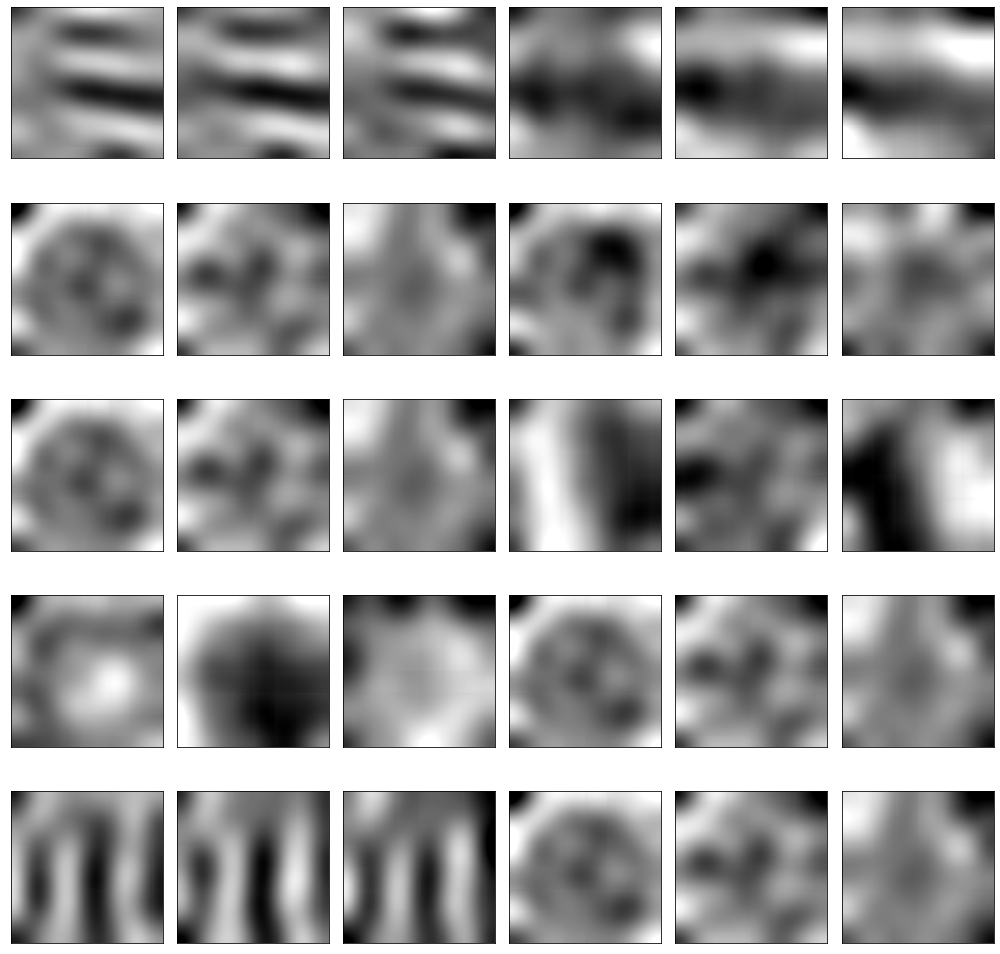

10


In [41]:
visualizeFilter(4)